## Deep Learning Reproduction Project on Pre-Trained Vision Transformer 
#### Name: Omar Sharif 
#### UID: 01093569
#### Course : Funadementals of Deep Learning 
#### Instructor: Dr. Jian Wu 
 

## Project Overview
Attention based tranformer models have shown improvement in good margin on natural language procesisng tasks. Research community focused on how the transformer model can uitilized on Image datasets to solve vision based applications. Vision transformers<sup>[1]</sup> were proposed and showed robust performance on tasks such as image classfication and object detection. The application expanded many applications. Inspired by these developments, my project is about reproduction of pretrained vision tranformers. This reproduction is inspired from mainly two papers one is headlined  Vision transformers for classification of breast ultrasound images <sup>[2]</sup> where pretrained vision transformers were used to train breast ultrasound image datasets. Another paper is named ViT-DeiT: An Ensemble Model for Breast Cancer Histopathological Images Classification <sup>[3]</sup> where one of their experiment contains training a vision transformers on breast cancer histopathological dataset(BreakHis)<sup>[4]</sup>. I this study I experimented with 4 variants of pretrained vision transformers on BreakHis dataset. The details of the experiments are as follows.   

In [1]:
import tensorflow as tf
import numpy as np
import os
from vit_keras import vit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, auc, classification_report, accuracy_score
from tensorflow.keras.regularizers import l2
import tensorflow_addons as tfa

## Dataset 
I used BreakHis dataset. Because of limitaions of resources I used a portion of the dataset. The training data has 1045 images, 400 images are used for validation and another 400 images are taken from testing. The training images are augmented with flipping horizontally and vertically. Also the image zooming was performed. 

In [2]:
train_dir = 'D:\\Dataset\\breast\\train'
val_dir = 'D:\\Dataset\\breast\\validation'
test_dir = 'D:\\Dataset\\breast\\test'
batch_size = 8
IMG_SIZE = 224
num_classes = 2

In [3]:
train_datagen = ImageDataGenerator( 
    rescale=1./255,
    horizontal_flip = True,
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True
)

In [4]:
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    
    shuffle = False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False
    
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode = None,
    shuffle = False
    
)

Found 1045 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


### Methods 

Two variants of pre trained vision transformers were used. The b16 is dubbed big transformer model and has 16 tranformer blocks. Similarly, b32 has 32 transformer blocks. Because of the limitation of resources I wasn't able to run l_16 and l32 variants.All the models were pretrained on ImageNet21K dataset. A dense layer was added with every model to obtain the classification output. Adam optimizer was used with learning rate of 1e-4 and training was ran on 25 epochs.  

In [7]:
vit_model = vit.vit_b16(
    image_size=IMG_SIZE,
    
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=num_classes,
)

c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [8]:
classification_layer = tf.keras.layers.Dense(2, activation='softmax')
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = vit_model(inputs)
outputs = classification_layer(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [9]:
model.compile(
    optimizer=tf.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [10]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)
callbacks = [earlystopping, reduce_lr]
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks = callbacks
)


Epoch 1/25
131/131 [==============================] - 179s 1s/step - loss: 0.9357 - accuracy: 0.5397 - val_loss: 0.7053 - val_accuracy: 0.4950 - lr: 1.0000e-04
Epoch 2/25
131/131 [==============================] - 122s 920ms/step - loss: 0.7689 - accuracy: 0.6019 - val_loss: 1.2007 - val_accuracy: 0.5075 - lr: 1.0000e-04
Epoch 3/25
131/131 [==============================] - 93s 711ms/step - loss: 0.5455 - accuracy: 0.7483 - val_loss: 1.4154 - val_accuracy: 0.5100 - lr: 1.0000e-04
Epoch 4/25
131/131 [==============================] - 92s 699ms/step - loss: 0.4032 - accuracy: 0.8268 - val_loss: 1.5328 - val_accuracy: 0.4625 - lr: 1.0000e-04
Epoch 5/25
131/131 [==============================] - 87s 667ms/step - loss: 0.3784 - accuracy: 0.8163 - val_loss: 2.3246 - val_accuracy: 0.5750 - lr: 1.0000e-04
Epoch 6/25
131/131 [==============================] - 88s 667ms/step - loss: 0.3205 - accuracy: 0.8718 - val_loss: 1.6177 - val_accuracy: 0.5025 - lr: 1.0000e-04
Epoch 7/25
131/131 [=========

50/50 [==============================] - 25s 383ms/step
Accuracy score: 0.87
confusion matrix
[[148  52]
 [  0 200]]


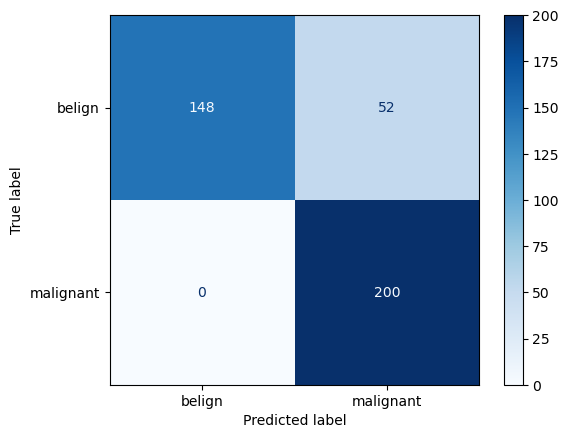

In [11]:
pred = model.predict(test_generator)
y_pred = np.argmax(pred, axis = 1)
accuracy =  accuracy_score(test_generator.classes, y_pred)
print('Accuracy score:', accuracy)
cm = confusion_matrix(test_generator.classes, y_pred)
print('confusion matrix')
print(cm)

cm_display = ConfusionMatrixDisplay(cm, display_labels = ['belign', 'malignant']).plot(cmap=plt.cm.Blues)

## Result evaluation 

Accuracy and confusion matrix shows very good result. Which is way below than this paper's<sup> 3</sup> result. The reason is I used a portion of this dataset that has fewer samples. Model did not able to learn properly from less amount of data. 

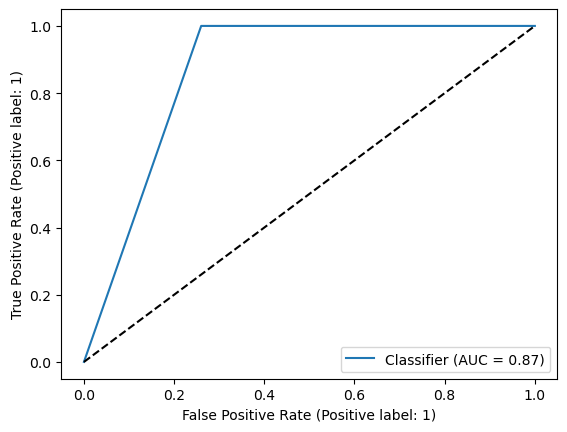

In [12]:
RocCurveDisplay.from_predictions(test_generator.classes, y_pred)
plt.plot([0, 1], [0, 1], "k--")

For similar reason the roc curve results are slightly lower than the original paper. 

(0.43758672922849656, 1.0)

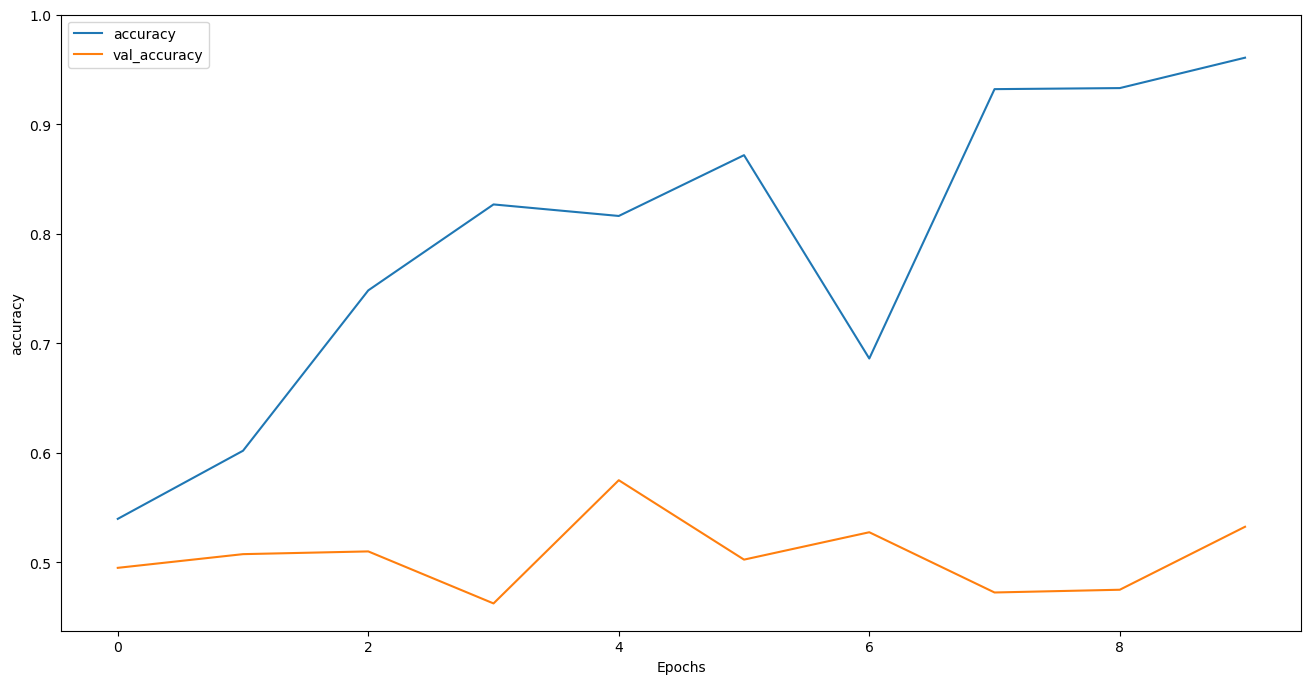

In [13]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 8))
#plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.ylim(None, 1)
#plt.savefig('vit_mnist_accuracy.png')




(0.0, 2.434311243891716)

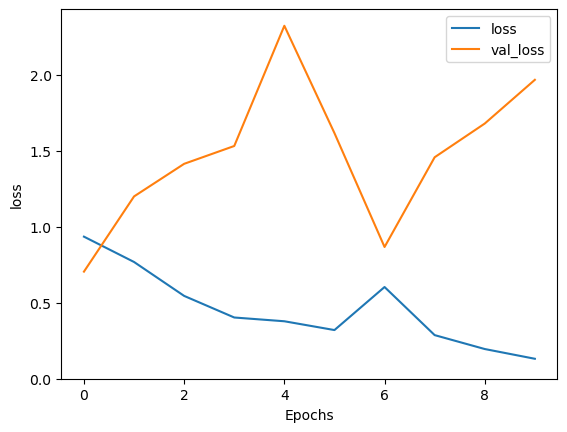

In [14]:
plot_graphs(history, 'loss')
plt.ylim(0, None)

Accuracy trend shows some fulctuations initially but became stable over the epochs. 

In [15]:
report = classification_report(test_generator.classes, y_pred, target_names=['normal', 'abnormal'])
print(report)

              precision    recall  f1-score   support

      normal       1.00      0.74      0.85       200
    abnormal       0.79      1.00      0.88       200

    accuracy                           0.87       400
   macro avg       0.90      0.87      0.87       400
weighted avg       0.90      0.87      0.87       400



Here is the classfication report showing precision recall and f1-score along with accuracy. 
Now, training with vitb_32 pretrained model. 

In [6]:
vit_model_b32 = vit.vit_b32(
    image_size=IMG_SIZE,
    
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=num_classes,
)


c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


In [7]:
classification_layer = tf.keras.layers.Dense(2, activation='softmax')
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = vit_model_b32(inputs)
outputs = classification_layer(x)
model_b32 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model_b32.compile(
    optimizer=tf.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


In [9]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)
callbacks = [earlystopping, reduce_lr]


In [10]:
history = model_b32.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks = callbacks
)


Epoch 1/25
131/131 [==============================] - 120s 729ms/step - loss: 0.8715 - accuracy: 0.5455 - val_loss: 0.8511 - val_accuracy: 0.4300 - lr: 1.0000e-04
Epoch 2/25
131/131 [==============================] - 56s 427ms/step - loss: 0.5489 - accuracy: 0.7158 - val_loss: 1.8883 - val_accuracy: 0.3650 - lr: 1.0000e-04
Epoch 3/25
131/131 [==============================] - ETA: 0s - loss: 0.4977 - accuracy: 0.7608
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
131/131 [==============================] - 54s 416ms/step - loss: 0.4977 - accuracy: 0.7608 - val_loss: 1.1856 - val_accuracy: 0.4050 - lr: 1.0000e-04
Epoch 4/25
131/131 [==============================] - 41s 312ms/step - loss: 0.2235 - accuracy: 0.9215 - val_loss: 1.7162 - val_accuracy: 0.4800 - lr: 2.0000e-05
Epoch 5/25
131/131 [==============================] - 47s 357ms/step - loss: 0.2227 - accuracy: 0.9225 - val_loss: 1.7149 - val_accuracy: 0.4075 - lr: 2.0000e-05
Epoch 6/25
131/131 [=======

50/50 [==============================] - 5s 86ms/step
0.915
confusion matrix
[[173  27]
 [  7 193]]


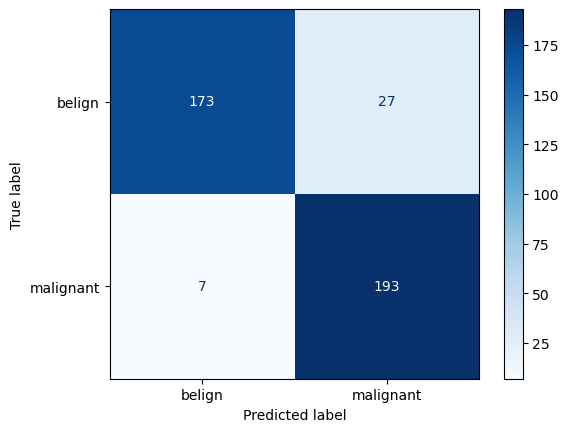

In [16]:
pred = model_b32.predict(test_generator)
y_pred = np.argmax(pred, axis = 1)
accuracy =  accuracy_score(test_generator.classes, y_pred)
print(accuracy)
cm = confusion_matrix(test_generator.classes, y_pred)
print('confusion matrix')
print(cm)

cm_display = ConfusionMatrixDisplay(cm, display_labels = ['belign', 'malignant']).plot(cmap=plt.cm.Blues)

Accuracy and confusion matrix did not show Improvement. As the ViT_b32 has more attention models that can learn and extract features more efficiently.  

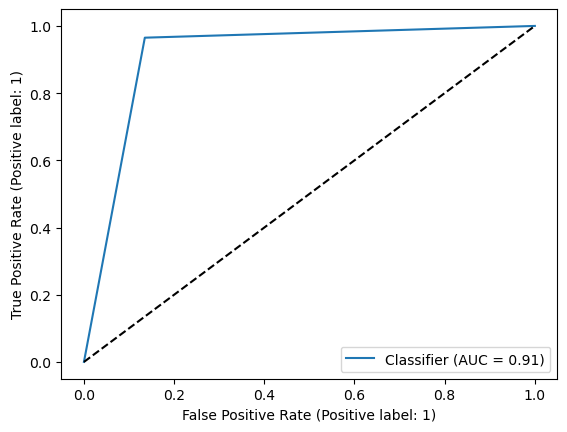

In [17]:
RocCurveDisplay.from_predictions(test_generator.classes, y_pred)
plt.plot([0, 1], [0, 1], "k--")
plt.show()

Roc curve also shows the same trend. 

(0.3347332626581192, 1.0)

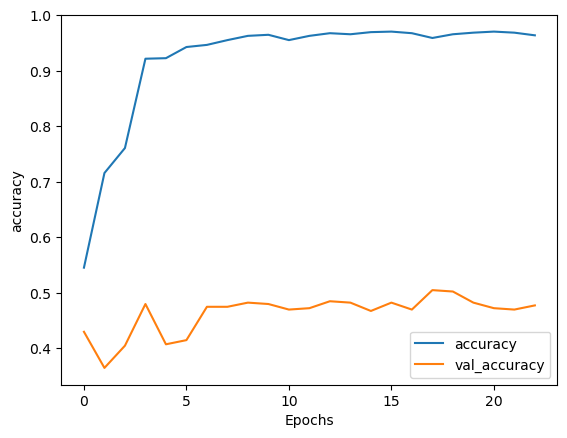

In [13]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plot_graphs(history, 'accuracy')

plt.ylim(None, 1)

Accuracy curve does show improvement over the epochs. 

(0.0, 3.067590744420886)

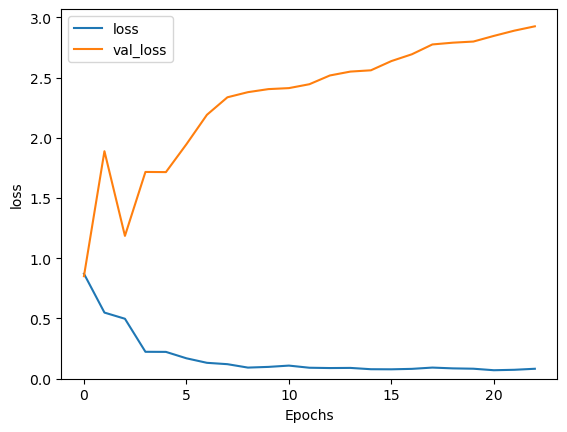

In [14]:
plot_graphs(history, 'loss')
plt.ylim(0, None)

One interesting observation is both accuracy and loss curves are more stable than b16. Which reflets that bigger ViTs has more parameters that learn and recognizes features better than smaller models. 

In [15]:
report = classification_report(test_generator.classes, y_pred, target_names=['benign', 'malignant'])
print(report)

              precision    recall  f1-score   support

      benign       0.96      0.86      0.91       200
   malignant       0.88      0.96      0.92       200

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.91       400
weighted avg       0.92      0.92      0.91       400



Classification reports shows that the metrics precision, recall and f1-scores has better results. 

In [11]:
#resize iamges to 384,384
IMG_SIZE_L = 384
train_datagen = ImageDataGenerator( 
    rescale=1./255,
    horizontal_flip = True,
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True
)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE_L, IMG_SIZE_L),
    batch_size=4,
    class_mode='categorical',
    
    shuffle = False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE_L, IMG_SIZE_L),
    batch_size=4,
    class_mode='categorical',
    shuffle = False
    
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE_L, IMG_SIZE_L),
    batch_size=4,
    class_mode = None,
    shuffle = False
    
)

Found 1045 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [13]:
vit_model_l16 = vit.vit_l16(
    image_size=IMG_SIZE_L,
    
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=num_classes,
)


ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[16,16,3,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

I tried to run the larger pretrain vision transformer models but my GPU has resource exhausted error which means my GPU memeory was not able handle huge parameters of the model. I used wahab clusters but 9 epochs ran 16 hours and still the model didn't coverge. I decided not to go for the experiment due to lack of time and resources. 

In [ ]:
classification_layer = tf.keras.layers.Dense(2, activation='softmax')
inputs = tf.keras.Input(shape=(IMG_SIZE_L, IMG_SIZE_L, 3))
x = vit_model_l16(inputs)
outputs = classification_layer(x)
model_l16 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_l16.compile(
    optimizer=tf.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)
callbacks = [earlystopping, reduce_lr]
history = model_l16.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks = callbacks
)



Epoch 1/25


ResourceExhaustedError: Graph execution error:

Detected at node 'model/vit-l16/Transformer/encoderblock_1/MultiHeadDotProductAttention_1/Softmax' defined at (most recent call last):
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\omarc\AppData\Local\Temp\ipykernel_24952\686487431.py", line 16, in <module>
      history = model_l16.fit(
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\vit_keras\layers.py", line 169, in call
      x, weights = self.att(x)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\vit_keras\layers.py", line 107, in call
      attention, weights = self.attention(query, key, value)
    File "c:\ProgramData\Miniconda3\envs\tf-exp\lib\site-packages\vit_keras\layers.py", line 90, in attention
      weights = tf.nn.softmax(scaled_score, axis=-1)
Node: 'model/vit-l16/Transformer/encoderblock_1/MultiHeadDotProductAttention_1/Softmax'
OOM when allocating tensor with shape[8,16,577,577] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/vit-l16/Transformer/encoderblock_1/MultiHeadDotProductAttention_1/Softmax}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_58496]

In [ ]:
pred = model_l16.predict(test_generator)
y_pred = np.argmax(pred, axis = 1)
accuracy =  accuracy_score(test_generator.classes, y_pred)
print('Accuracy score:', accuracy)
cm = confusion_matrix(test_generator.classes, y_pred)
print('confusion matrix')
print(cm)

cm_display = ConfusionMatrixDisplay(cm, display_labels = ['belign', 'malignant']).plot(cmap=plt.cm.Blues)


In [ ]:
RocCurveDisplay.from_predictions(test_generator.classes, y_pred)
plt.plot([0, 1], [0, 1], "k--")


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 8))
#plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.ylim(None, 1)
#plt.savefig('vit_mnist_accuracy.png')



plot_graphs(history, 'loss')
plt.ylim(0, None)


In [ ]:
report = classification_report(test_generator.classes, y_pred, target_names=['normal', 'abnormal'])
print(report)

In [ ]:
vit_model_l32 = vit.vit_l32(
    image_size=IMG_SIZE_L,
    
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=num_classes,
)


In [ ]:
classification_layer = tf.keras.layers.Dense(2, activation='softmax')
inputs = tf.keras.Input(shape=(IMG_SIZE_L, IMG_SIZE_L, 3))
x = vit_model_l32(inputs)
outputs = classification_layer(x)
model_l32 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_l32.compile(
    optimizer=tf.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)
callbacks = [earlystopping, reduce_lr]
history = model_l32.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks = callbacks
)



In [ ]:
pred = model_l32.predict(test_generator)
y_pred = np.argmax(pred, axis = 1)
accuracy =  accuracy_score(test_generator.classes, y_pred)
print('Accuracy score:', accuracy)
cm = confusion_matrix(test_generator.classes, y_pred)
print('confusion matrix')
print(cm)

cm_display = ConfusionMatrixDisplay(cm, display_labels = ['belign', 'malignant']).plot(cmap=plt.cm.Blues)


In [ ]:
RocCurveDisplay.from_predictions(test_generator.classes, y_pred)
plt.plot([0, 1], [0, 1], "k--")
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 8))
#plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.ylim(None, 1)
#plt.savefig('vit_mnist_accuracy.png')





In [ ]:
plot_graphs(history, 'loss')
plt.ylim(0, None)


In [ ]:
report = classification_report(test_generator.classes, y_pred, target_names=['normal', 'abnormal'])
print(report)

## Conclusion 
Vision transformers are robust in extracting better feature representations on image tasks. In particular, pretrianed vision transformers has better performance and the state-of-the-art of various vision tasks. My expriment reflects pretrain ViT models are able to quickly learn the features even in small amount sample data and nearly acheives the paper's experimental results. The future work will be to expriment with full dataset with sufficient hardware resources. Pretrained Vit models can also be experimented with other image that has complex representations.  

## References 

1. Dosovitskiy, Alexey, et al. "An image is worth 16x16 words: Transformers for image recognition at scale." arXiv preprint arXiv:2010.11929 (2020).

2. Gheflati, Behnaz, and Hassan Rivaz. "Vision transformers for classification of breast ultrasound images." 2022 44th Annual International Conference of the IEEE Engineering in Medicine & Biology Society (EMBC). IEEE, 2022.

3. Alotaibi, Amira, et al. "ViT-DeiT: An Ensemble Model for Breast Cancer Histopathological Images Classification." 2023 1st International Conference on Advanced Innovations in Smart Cities (ICAISC). IEEE, 2023.

4. https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/